Metemos todas las funciones aquí por comoidad

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy.integrate as inte

#para que en jupytter se vean mejor las graficas
%config InlineBackend.figure_format = 'svg'

# me gustan más estos colores para los plots
def colores_tableau():
    # Sources: http://www.randalolson.com/2014/06/28/how-to-make
    #            -beautiful-data-visualizations-in-python-with-matplotlib/
    # These are the "Tableau 20" colors as RGB.   
    tableau20=[(31, 119, 180),  (174, 199, 232), (255, 127, 14),  (255, 187, 120),    
               (44, 160, 44),   (152, 223, 138), (214, 39, 40),   (255, 152, 150),    
               (148, 103, 189), (197, 176, 213), (140, 86, 75),   (196, 156, 148),    
               (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
               (188, 189, 34),  (219, 219, 141), (23, 190, 207),  (158, 218, 229)]
    # Scale the RGB values to the [0, 1] range, which is the format matplotlib
    # accepts.    
    for i in range(len(tableau20)):    
        red, green, blue = tableau20[i]    
        tableau20[i] = (red / 255., green / 255., blue / 255.) 
    return tableau20

tableau20 = colores_tableau()

def write_directed_vertex_list_to_file(g, filename):
    A=np.array(g.edges())
    A=np.append(A,A[:,[1,0]], axis=0)
    A=np.array(A[A[:,0].argsort()]).astype(int)
    np.savetxt(filename, A, fmt='%i')
    
def velocity(t, y, arg1):
    c = arg1[0]
    w = arg1[1]
    A = arg1[2]
    y = np.matrix(y)
    ones = np.matrix(np.ones(NODE_NR)).T
    s=np.sin(ones*(y)-y.T*(ones.T))
    out = [(s[i]*A[i].T).item() for i in range(len(A))]
    return w+np.squeeze(np.asarray(c*np.matrix(out)))


def jacobian(t, y, arg2):
    c = arg2[0]
    neigh = arg2[1]
    #y = np.matrix(y)
    #ones = np.matrix(np.ones(NODE_NR)).T
    #s=np.cos(ones*(y)-y.T*(ones.T))
        
    jac = [[0 for j in range(0,NODE_NR)] for i in range(0,NODE_NR)]
    
    #diagonal terms
    for i in range(0,NODE_NR):
        suma = 0
        for j in neigh[i]:
            suma = suma + np.cos(y[j]-y[i]) 
        suma = -c*suma
        jac[i][i] = suma
    
    # off diagonal terms
    for i in range(0,NODE_NR):
        for j in neigh[i]:
            jac[i][j] =  c * np.cos(y[j]-y[i])
    
    return jac

def r_psi(theta,dt):
    z = sum(np.exp(theta*1j))/len(theta)
    lenz=len(z)
    weff_real = np.zeros(lenz)
    for i in range(0,lenz-1):
        weff_real[i] = np.angle(z[i+1]/z[i])/dt
    weff_real[lenz-1]=weff_real[lenz-2]
    
    
    weff_med = [np.diff(theta[i])/dt  for i in range(0,len(theta))]
    weff_med = sum(weff_med)/len(theta)
    weff_medida = np.zeros(lenz)
    for i in range(0,lenz-1):
        weff_medida[i] = weff_med[i]
    weff_medida[lenz-1] = weff_med[lenz-2]
    
    return np.array([np.absolute(z), np.angle(z), weff_real, weff_medida])

def r_psi_comp(theta, conn, dt):
    #z = (np.exp(theta*1j))
    # cada elto de out sera las r(t),psi(t) de una de las componentes disconexas
    out = []
    zc = 0
    weff_med = [np.diff(theta[i])  for i in range(0,len(theta))]
    for comp in conn:
        a = []
        for j in comp:
            # estamos metiendo todos los nodos j que pertenecem
            # a conn[i] en una lista para sumar despues
            a.append(np.exp(theta[j]*1j))  
        zc = sum(a)/len(comp)
        
        lenz=len(zc)
        ayx = np.zeros(lenz)
        for i in range(0,lenz-1):
            ayx[i] = np.angle(zc[i+1]/zc[i])/dt
        ayx[lenz-1]=ayx[lenz-2]
        weff_real = ayx

        b = []
        for j in comp:
            b.append(theta[j])
        bc = sum(b)/len(comp)
        abc = np.zeros(lenz)
        for i in range(0,lenz-1):
            abc[i] = (bc[i+1]-bc[i])/dt
        abc[lenz-1]=abc[lenz-2]
        weff_medida = abc
        
        out.append(np.array([np.absolute(zc), np.angle(zc),  weff_real, weff_medida]))
    return out

def without_transient(vec, t_transient):
    return vec[int(t_transient*(TIME_FINAL-TIME_INITIAL)/len(vec)) : -1]

def mean_sig_components (out_comp, t_transient):
    r_mean_comp = []
    r_sig_comp  = []
    w_r_mean_comp = []
    w_r_sig_comp = []
    w_m_mean_comp = []
    w_m_sig_comp = []
    for i in range(0,len(out_comp)):
        aux_vec_no_transient = without_transient(out_comp[i][0], t_transient)
        r_mean_comp.append(np.mean(aux_vec_no_transient))
        r_sig_comp.append(np.sqrt(np.var(aux_vec_no_transient)))
        
        aux_vec_no_transient = without_transient(out_comp[i][2], t_transient)
        w_r_mean_comp.append(np.mean(aux_vec_no_transient))
        w_r_sig_comp.append(np.sqrt(np.var(aux_vec_no_transient)))
        
        aux_vec_no_transient = without_transient(out_comp[i][3], t_transient)
        w_m_mean_comp.append(np.mean(aux_vec_no_transient))
        w_m_sig_comp.append(np.sqrt(np.var(aux_vec_no_transient)))
    return r_mean_comp, r_sig_comp, w_r_mean_comp, w_r_sig_comp, w_m_mean_comp, w_m_sig_comp
 
    
def plot_on_argand_plane(r, psi, out_comp):
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.title(r"Dibujo de $z=r(t)e^{i\theta (t)}$ total")
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    aux_r = r
    aux_psi = psi
    aux_n = len(aux_r)
    plt.plot(aux_r*np.cos(aux_psi),
             aux_r*np.sin(aux_psi),
             label=r"$z_{\mathrm{tot}}$",
             color = 'gray')
    plt.legend()

    plt.subplot(1,2,2)
    plt.title(r"Dibujo de $z=r(t)e^{i\theta (t)}$ de las comptes")
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    for i in range(0,len(out_comp)):
        aux_r = out_comp[i][0]
        aux_psi = out_comp[i][1]
        aux_n = len(aux_r)
        plt.plot(aux_r*np.cos(aux_psi),
                 aux_r*np.sin(aux_psi),
                 label=r"$z_{"+str(i)+"}$")
    plt.legend()
    
def plot_generic(r, psi,weff_real, weff_medida, out_comp):
    #plt.rc('text', usetex=True)
    #plt.rc('font', family='serif')
    #plt.style.use('ggplot')
    #plt.style.use('seaborn-talk')

    plt.figure(figsize=(10,6))

    time = t

    plt.subplot(2, 2, 1)
    plt.ylim([0,1.1])
    plt.title("Magnitudes totales")
    plt.plot(time,r,color=tableau20[0])#,label=r"$r$")
    plt.ylabel('$r_{\mathrm{tot}}$')
    
    plt.subplot(2, 2, 3)
    #plt.ylim([-np.pi,+np.pi])
    plt.plot(time,psi,color=tableau20[1],label=r"$\psi$")
    plt.plot(time, weff_real, color=tableau20[0],label=r"$\omega_{\mathrm{real}}$")
    #plt.plot(time, weff_medida, color=tableau20[2],label=r"$\omega_{\mathrm{approx}}$")
    plt.ylabel('$\psi_{\mathrm{tot}}$')
    plt.xlabel('$t$')
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.title("Magnitudes clusters, de mayor a menor (de 0 a ....)")
    plt.ylim([0,1.1])
    for i in range(0,len(out_comp)):
        plt.plot(time,out_comp[i][0],label=r"$r_"+str(i)+"$")
    plt.ylabel(r'$r_{i}$')
    plt.legend()
    
    plt.subplot(2, 2, 4)
    #plt.ylim([-np.pi,+np.pi])
    for i in range(0,len(out_comp)):
        plt.plot(time,out_comp[i][1],label=r"$\psi_"+str(i)+"$")
        plt.plot(time, out_comp[i][2],label=r"$\omega_{\mathrm{real}}$-"+str(i))
        #plt.plot(time, out_comp[i][3],label=r"$\omega_{\mathrm{approx}}$-"+str(i))
    plt.ylabel(r'$\psi_{i}$')
    plt.xlabel(r'$t$')
    plt.legend()
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                        wspace=0.35)
    

#METHOD = 'RK45'
#ints = solve_ivp(lambda t,y: velocity(t,y,[COUPLING,w,A]),
#                y0=theta_0,
#                t_span=[TIME_INITIAL,TIME_FINAL],
#                method=METHOD,
#                dense_output=False)

Ahora vamos a definir la red sobre la que realizaremos la simulación.

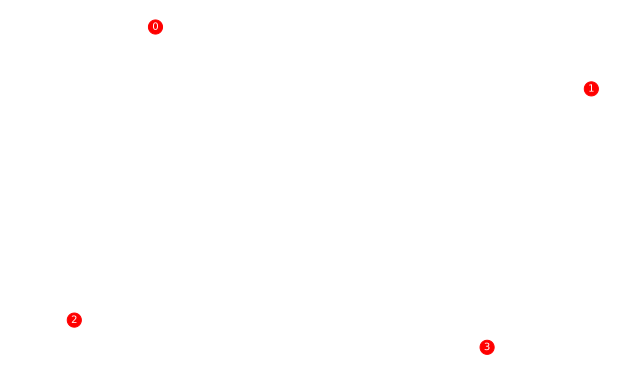

In [46]:
g=nx.Graph()

for i in range(0,4):
    g.add_node(i)
#g.add_node(60)

#Ahora definimos 4 componentes: dos grandes, dos pequeñas. Quiero que tenga dos sincronizadas y dos sin sincronizar.
# los nodos extra estan para simular"otras componentes sincronziadas" me dan igual cuales son
'''
g.add_edge(39,38)
g.add_edge(37,36)
g.add_edge(35,34)
'''

#g.add_edge(1,2)
#g.add_edge(1,3)
#g.add_edge(1,4)
#g.add_edge(4,3)
#g.add_edge(4,0)
#g.add_edge(8,7)
'''
g.add_edge(7,6)
g.add_edge(2,8)
g.add_edge(6,4)
g.add_edge(6,8)
g.add_edge(6,2)
g.add_edge(7,9)


g.add_edge(21,22)
g.add_edge(21,23)
g.add_edge(21,25)
g.add_edge(21,24)
g.add_edge(24,23)
g.add_edge(20,19)
g.add_edge(19,26)
g.add_edge(22,20)
g.add_edge(26,24)
g.add_edge(26,25)
g.add_edge(26,22)
g.add_edge(25,20)


g.add_edge(11,12)
g.add_edge(12,18)
g.add_edge(15,18)


g.add_edge(17,10)
g.add_edge(17,5)
g.add_edge(17,16)

g.add_edge(13,14)
g.add_edge(13,0)

'''
#sueltos:
#0
#17
#19

# comentarios con acoplo 5
#g.add_edge(8,24) 
#g.add_edge(12,16) 
#g.add_edge(12,8)
#g.add_edge(7,16) 
#g.add_edge(12,23)
#g.add_edge(22,5)

#g = nx.barabasi_albert_graph(10, 3)
#write_directed_vertex_list_to_file(g,'net.net')

#E=np.loadtxt('net.net')
NODE_NR = g.number_of_nodes()

A = nx.adjacency_matrix(g)
A = nx.to_numpy_matrix(g)

C = np.zeros((int(NODE_NR),int(NODE_NR)))-1
for i in range(0,NODE_NR):
    k=0
    for j in range(0,NODE_NR): 
        if A[i,j]!=0:
            C[i][k]=j
            k = k + 1
            
#g=nx.read_adjlist("net.net")

# Lo siguiente es para tener las componentes separadas.
connctd = sorted(nx.connected_components(g), key=len, reverse=True)
connctd = [np.array((list(i)),dtype=int) for i in connctd]
mat_C = []
for comp in connctd:
    mat_C.append(np.zeros(NODE_NR))
    for j in range(0,len(comp)):
        mat_C[-1][comp[j]] = 1
mat_C = np.array(mat_C)

neighbors = [[] for i in range(0,NODE_NR)]
for i in range(0,NODE_NR):
    for j in range(0,NODE_NR):
        if C[i][j]!=-1:
            neighbors[i].append(int(C[i][j]))

plt.figure(figsize=(8,5))

#print(g.nodes())
nx.draw(g,pos=nx.spring_layout(g), node_size=200, with_labels=True,font_size=10, font_color='white') 

Condiciones iniciales

In [47]:
np.random.seed(77)
w=-0.5+(0.5--0.5)*np.random.rand(NODE_NR)
#w=np.random.normal(0, 1, NODE_NR)
theta_0 = -np.pi + 2*np.pi*np.random.rand(NODE_NR)
COUPLING = 1.0

Integracion. Uso un metodo algo ineficiente, pero para pocos nodos debería darigual

In [48]:
TIME_INITIAL = 0.0
TIME_FINAL = 100.0
#DT = (TIME_FINAL-TIME_INITIAL)/100
DT = 0.01
INTEGRATOR = 'lsoda'

ode = inte.ode(lambda t,y: velocity(t,y,[COUPLING,w,A]),
               lambda t,y: jacobian(t,y,[COUPLING,neighbors]))
ode.set_integrator(INTEGRATOR)
ode.set_initial_value(theta_0, TIME_INITIAL)


t = []
t.append(ode.t)
ode.integrate(ode.t + DT)
y_t = ode.y
#y_t_dot = velocity(0, y_t, [COUPLING,w,A])
y_t = [[y_t[i]] for i in range(0,NODE_NR)]
#y_t_dot = [[y_t_dot[i]] for i in range(0,NODE_NR)]
while ode.successful() and ode.t < TIME_FINAL:
    ode.integrate(ode.t + DT)
    t.append(ode.t)
    for i in range(0, NODE_NR):
        y_t[i].append(ode.y[i])
#        y_t_dot[i].append(velocity(0, ode.y[i], [COUPLING,w,A]))
#print(y_t[0])
y_t = [np.array(y_t[i]) for i in range(0,len(y_t))]
y_t = np.array(y_t)

#asd = ints.y
asd = y_t
print(y_t[0])

[-2.58875666 -2.58456557 -2.58037448 ... 39.30957325 39.31376434
 39.31795543]


In [49]:
out_comp = r_psi_comp(asd, connctd, DT)
r, psi, weff_real, weff_medida = r_psi(asd, DT)
TRANSIENT = 20

r_without_transient = without_transient(r, TRANSIENT)
r_mean = np.mean(r_without_transient)
r_var = np.sqrt(np.var(r_without_transient))

weff_medida_without_transient = without_transient(weff_real, TRANSIENT)
w_mean = np.mean(weff_medida_without_transient)
w_var = np.sqrt(np.var(weff_medida_without_transient))
     
r_mean_comp, r_sig_comp, w_r_mean_comp, w_r_sig_comp, w_m_mean_comp, w_m_sig_comp = mean_sig_components(out_comp, TRANSIENT)



Ahora tocan plots. La $\omega_{\mathrm{real}}$ se calcula como la derivada temporal de $\psi$ de $re^{i\psi}=\sum e^{i\theta_i}$. La llamo "real" porque no es promedio de $\dot{\theta}_i$, sino es la derivada de la fase global.

Promedios totales:
r total = 0.47+-0.22
w total = 0.22+-1.17
Por componentes:
r_comp:  ['1.00+-0.00', '1.00+-0.00', '1.00+-0.00', '1.00+-0.00']
w_comp:  ['0.42+-0.00', '0.14+-0.00', '0.25+-0.00', '-0.36+-0.00']
w:  ['0.42', '0.14', '0.25', '-0.36']
comptes: [array([0]), array([1]), array([2]), array([3])]


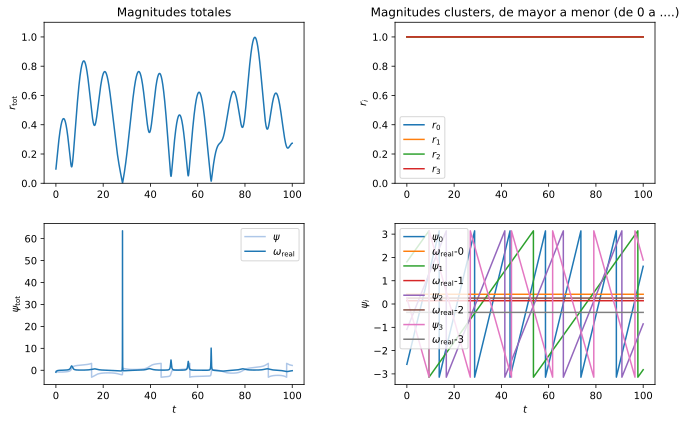

In [50]:
print("Promedios totales:")
print("r total = "+"{:.2f}".format(r_mean)+"+-"+"{:.2f}".format(r_var))
print("w total = "+"{:.2f}".format(w_mean)+"+-"+"{:.2f}".format(w_var))

print("Por componentes:")
print("r_comp: ",["{:.2f}".format((r_mean_comp[i]))+"+-"+"{:.2f}".format(np.sqrt(np.var(out_comp[i][0])))
                   for i in range(0,len(r_mean_comp))])
print("w_comp: ",["{:.2f}".format((w_r_mean_comp[i]))+"+-"+"{:.2f}".format(np.sqrt(np.var(out_comp[i][2])))
                   for i in range(0,len(w_r_mean_comp))])
print("w: ",["{:.2f}".format((w[i])) for i in range(0,len(w))])
print("comptes:",connctd)

plot_generic(r, psi, weff_real, weff_medida, out_comp)

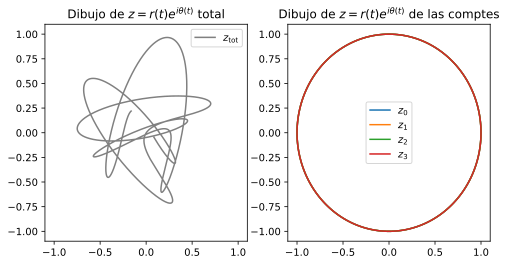

In [51]:
plot_on_argand_plane(r, psi, out_comp)

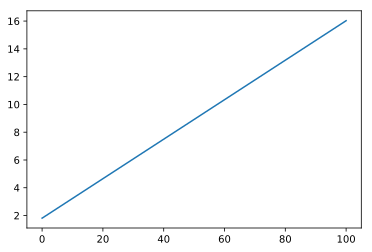

In [52]:
plt.plot(t,y_t[1])